In [23]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import shuffle
import random
np.set_printoptions(threshold=np.inf)

batch_size = 32  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 26000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'many_to_one_dataset.txt'
print(epochs)

150


In [24]:
data_path = 'dataset(only_bigram).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
file = open('dataset(only_bigram_test).txt','w',encoding="utf-8")    
for line in lines:
    data=line.split()
    #print(len(data))
    if(len(data)==3):
        continue
    input_text, target_text = line.split('\t')
    data=input_text.split(' ')
    line=input_text+'\t'+data[0]+' '+target_text+' '+data[2]+'\n'
    file.write(line)
    
file.close() 

In [25]:
# Vectorize the data.
data_path = 'dataset(only_bigram_test).txt'
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    print(len(lines))
    print(lines[0])
    random.shuffle(lines)
    print(lines[0])
    
num_samples=37000    
for line in lines[: min(num_samples, len(lines) - 1)]:
    print(line)
    input_text, target_text = line.split('\t')
    # We use tab('\t') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

10119
স্মৃতিকথায় ঢাকার অলিগলি-তস্যগলি—মৈশণ্ডীপাড়া,	স্মৃতিকথায় ঢাকা অলিগলি-তস্যগলি—মৈশণ্ডীপাড়া,
অন্যতম একটি উপায়।	অন্যতম এক উপায়।
অন্যতম একটি উপায়।	অন্যতম এক উপায়।
বিস্ফোরিত হয়। এতে	বিস্ফোরিত হয়। এতে
হলো ঔপনিবেশিক ও	হলো ঔপনিবেশিক ও
বাসের সঙ্গে অটোরিকশাটির	বাসের সঙ্গ অটোরিকশাটির
একবার হাত ঘুরিয়ে	একবার হাত ঘুরিয়ে
সুখের বাতাস। মুখে	সুখের বাতাস মুখে
পথে তাঁরা মারা	পথে তাঁরা মারা
উঠছে, তাই যাদের	উঠছে, তাই যাদের
গানটি ছিল। এই	গানটি ছিল। এই
মৃত্যু হয়। মংলা	মৃত্যু হয় মংলা
বাসার মধ্যে। উত্তেজিত	বাসার মধ্য। উত্তেজিত
করে বসে সেখানেই।	করে বস সেখানেই।
খ্রিষ্টানধর্ম হচ্ছে শারীরিক	খ্রিষ্টানধর্ম হচ্ছে শারীরিক
মুণ্ডা তুকে ভালোবাছে।	মুণ্ডা তুক ভালোবাছে।
তিন যাত্রী নিহত	তিন যাত্রী নিহত
১২ মে ২০১২	১২ মে ২০১২
প্রকাশিত ক্রিকেটকে ঘিরে	প্রকাশিত ক্রিকেট ঘিরে
বসবাস করে আসছেন।	বসবাস কর আসছেন।
বাসে ধরিয়ে দেয়।	বাসে ধরি দেয়।
সাহিত্যে এই খেলার	সাহিত্যে এই খেলার
খোঁপার ফুল খসে	খোঁপার ফুল খসে
১ মে দিবস।	১ মে দিবস।
পড়ার সময় আমি	পড়ার সময় আমি
মঙ্গলবার বাসের চাপায়	মঙ্গলবার বাস চাপায়
ঢালাইয়ের কাজ শুরু	ঢালা

উল্লেখ করেছেন। সাসুনের	উল্লেখ কর। সাসুনের
তাঁর কবিতাও পাঠিয়েছিলেন;	তাঁর কবিতা পাঠিয়েছিলেন;
কারণে গানের ডাক	কারণে গান ডাক
বলেন যে বাংলাদেশে	বলেন যে বাংলাদেশে
নাগের নেতৃত্বে চট্টগ্রাম	নাগের নেতৃত্ব চট্টগ্রাম
অন্য দুধরনের কাজের	অন্য দুধরন কাজের
সংখ্যাটির এ বিশেষ	সংখ্যাটির এ বিশেষ
ও খুলনা মেডিকেল	ও খুলনা মেডিকেল
নিয়ে মেতে থাকা	নিয়ে মেতে থাকা
কেরানিবাবু দিলেও দিতে	কেরানিবাবু দিল দিতে
সাকতে তুমহারা বিনা...।’	সাকতে তুমহারা বিনা...।’
উঠতে না পারায়	উঠতে না পারায়
ক্রিকেট আর্জ দ্য	ক্রিকেট আর্জ দ্য
মেডিকেল কলেজের বার্ন	মেডিকেল কলেজ বার্ন
যেকোনো তরুণ বয়সী	যেকোনো তরুণ বয়সী
উইথ আ ভেনজিয়েন্স’	উইথ আ ভেনজিয়েন্স’
তোরা সুখী হবি।’	তোরা সুখী হবি।’
নিহত হওয়া দুজন	নিহত হওয়া দুজন
শ্রেষ্ঠত্বের দাবিদার তিনি।	শ্রেষ্ঠত্বের দাবিদার তিনি।
এগিয়ে যায় প্রগতিসড়ক	এগিয়ে যায় প্রগতিসড়ক
ঔপনিবেশিক শাসনের বিরুদ্ধে	ঔপনিবেশিক শাসন বিরুদ্ধে
ইংরেজি সাম্রাজ্যবাদী ভাষা,	ইংরেজি সাম্রাজ্যবাদ ভাষা,
ধরিয়ে সহপাঠি সামিয়ার	ধরিয়ে সহপাঠি সামিয়ার
সোনারতরী লঞ্চ থেকে	সোনারতরী লঞ্চ থেকে
উপজেলার দোকানঘর এলাকার	উপজেলার দোকানঘর এলাকার


ছিল ঢাকা শহর,	ছিল ঢাকা শহর,
বেঙ্গল লাউঞ্জে শিল্পীর	বেঙ্গল লাউঞ্জ শিল্পীর
বল।’ অন্যদিকে চালর্স	বল।’ অন্যদিক চালর্স
পাঠ করার পর	পাঠ কর পর
‘ঢাকার সবচেয়ে ভদ্রপাড়া	‘ঢাকার সবচেয়ে ভদ্রপাড়া
১৩০০ সালে যুবরাজ	১৩০০ সাল যুবরাজ
চিত্রে দেখা যায়,	চিত্রে দেখা যায়,
গেছে বলে বুদ্ধদেব	গেছে বল বুদ্ধদেব
ছত্রছাল গ্রামের মৃত	ছত্রছাল গ্রাম মৃত
করে কক্সবাজার ১৭	করে কক্সবাজার ১৭
তুমহারা বিনা...।’ ২.	তুমহারা বিনা...।’ ২.
রানা। তাঁদের মধ্যে	রানা। তাঁদের মধ্যে
কাজ করেছিল, তার	কাজ কর, তার
সুধীর রায়ের সঙ্গে।	সুধীর রায় সঙ্গে।
এই মানিক মুণ্ডা	এই মানিক মুণ্ডা
সহজ সরল অদাম্ভিক	সহজ সরল অদাম্ভিক
ওই জায়গায় রিকুইজিশন	ওই জায়গা রিকুইজিশন
নিহত ব্যক্তিদের মধ্যে	নিহত ব্যক্তি মধ্যে
তখনকার সমস্ত গান	তখনকার সমস্ত গান
তাদের মধ্যে মিল	তাদের মধ্য মিল
কারণে এ দুর্ঘটনা	কারণে এ দুর্ঘটনা
বড় স্পেস শূন্য	বড় স্পেস শূন্য
জাহেদুল বনপাড়া মডেল	জাহেদুল বনপাড়া  মডেল
নিয়ে মেতে উঠলেন	নিয়ে মেতে উঠলেন
নোটিশ, মে ২০১৮	নোটিশ, মে ২০১৮
কী অপার আকর্ষণ	কী অপার আকর্ষণ
কী সুন্দর লাগছে!’	কী সুন্দর লাগছে!’
মা-মেয়েসহ তিনজন নিহত	মা-মেয়েসহ তিন নিহত
আবার জ

হাতে উপহারের প্যাকেট	হাতে উপহার প্যাকেট
মোস্তফা কামাল (৫০)	মোস্তফা কামাল (৫০)
ওকে মানিকদা বলে	ওকে মানিকদা বলে
হয়েছে। জাহেদুল বনপাড়া	হয়েছে। জাহেদুল বনপাড়া
শর্টসার্কিট থেকে আগুনের	শর্টসার্কিট থেকে আগুনের
শিকল তুলে বের	শিকল তুলে বের
বুধবার দিবাগত রাত	বুধবার দিবাগত রাত
মিশিয়ে উপনিবেশিতদের মন	মিশিয়ে উপনিবেশিত মন
সোম’ নামে। গ্রামোফোন	সোম’ নাম। গ্রামোফোন
মাইক ছিল না,	মাইক ছিল না,
গড়া তাঁর চরিত্র।	গড়া তাঁর চরিত্র।
কবিবন্ধু সুফী মোতাহার	কবিবন্ধু সুফী মোতাহার
আয় করেছে সবচেয়ে	আয় কর সবচেয়ে
করে বর্ণ ও	করে বর্ণ ও
নির্ভর করে তা	নির্ভর কর তা
ও সিলেট থেকে	ও সিলেট থেকে
সাংস্কৃতিক জীবনের চমৎকার	সাংস্কৃতিক জীবন চমৎকার
আবুল দোকানি মুণ্ডা	আবুল দোকানি মুণ্ডা
আগেই জানতেন দিলীপকুমার;	আগেই জানত দিলীপকুমার;
প্রচ্ছদ পরিকল্পনা ও	প্রচ্ছদ পরিকল্পনা ও
হয় নৈতিকতার সঙ্গে,	হয় নৈতিক সঙ্গে,
দিকে একটি বসতঘর	দিকে এক বসতঘর
কাজ শুরু হয়।	কাজ শুরু হয়।
এ ছাড়া খুলনা	এ ছাড়া খুলনা
সিনেমা দেখবে না।	সিনেমা দেখ না।
করেন। ধসে পড়া	করেন। ধস পড়া
১০টি বসতঘরে ১০টি	১০টি বসতঘর ১০টি
জিয়াউর রহমান মেডিকেল	জিয়াউর রহমান মেডিক

ইংল্যান্ডের নয়নাভিরাম গ্রামাঞ্চলের	ইংল্যান্ডের নয়নাভিরাম গ্রামাঞ্চলের
গাজীপুর জেলা প্রশাসক	গাজীপুর জেলা প্রশাসক
ঘইষব গো কেরানিবাবু,	ঘইষব গো কেরানিবাবু,
নির্বাচিত অংশ দেখলে	নির্বাচিত অংশ দেখলে
তাঁর ‘দিনপঞ্জি-মনপঞ্জি’ লিখেছিলেন	তাঁর ‘দিনপঞ্জি-মনপঞ্জি’ লিখেছিলেন
সময় মা তাকে	সময় মা তাকে
এতে করে সহজেই	এতে কর সহজেই
প্রণয়। দুজনের বিবাহবন্ধনে	প্রণয়। দুজন বিবাহবন্ধনে
মাসুক হেলাল ৫৮৪	মাসুক হেলাল ৫৮৪
গান শিখতে গিয়েই	গান শিখ গিয়েই
শেষ হওয়ার কথা।	শেষ হয় কথা।
বোধহয় তিনখানা না	বোধহয় তিন না
(গ্রেইটনেস) বড় ইস্যুর	(গ্রেইটনেস) বড় ইস্যুর
আছে, একখান ঘর	আছে, একখান ঘর
পোশাক কারখানায় চাকরি	পোশাক কারখানা চাকরি
রাস্তায় ছিটকে পড়েন।	রাস্তায় ছিটকে পড়েন।
এতে তিনি দগ্ধ	এতে তিনি দগ্ধ
উপপরিদর্শক (এএসআই) জাহিদুল	উপপরিদর্শক (এএসআই) জাহিদুল
মিলু বলল, ‘মা,	মিলু বল, ‘মা,
শিক্ষা, যেটি তাদের	শিক্ষা, যে তাদের
নেভাতে গিয়ে আহত	নেভাতে গিয়ে আহত
দৃষ্টিভঙ্গিতে, ভিন্ন ভিন্ন	দৃষ্টিভঙ্গিতে, ভিন্ন ভিন্ন
পুরানা পল্টনে, অজিত	পুরানা পল্টন, অজিত
সুন্দর বটে তব	সুন্দর বটে তব
উঠেছি আমরা। ছাত্রজীবনেই	উঠেছি আমরা ছাত্রজীবনেই
(ব্র্যাডম্

গিলেস্পির পূর্ণ শক্তির	গিলেস্পির পূর্ণ শক্তির
গঠন করা হয়েছে।	গঠন কর হয়েছে।
বঙ্গবন্ধু সেতু পশ্চিম	বঙ্গবন্ধু সেতু পশ্চিম
খ্যাত লর্ডস মাঠে	খ্যাত লর্ডস মাঠে
যে ইতিবৃত্ত তাঁর	যে ইতিবৃত্ত তাঁর
তাঁর সহধর্মিণী লিলি	তাঁর সহধর্মিণী লিলি
হলেন রামপাল উপজেলার	হলেন রামপাল উপজেলার
দিলীপকুমার রায় প্রেরিত	দিলীপকুমার রায় প্রেরিত
বিবেচিত হবে, এ	বিবেচিত হবে, এ
শুক্রবার দুপুরে ধ্বংসস্তূপ	শুক্রবার দুপুর ধ্বংসস্তূপ
সূত্র: ওয়ার্ল্ড লিটারেচার	সূত্র: ওয়ার্ল্ড লিটারেচার
মধ্যে পান, কিন্তু	মধ্যে পান, কিন্তু
কোথায় মানিক মেথর!	কোথায় মানিক মেথর!
ক্রীড়ালেখকদের ক্রিকেটের মাধ্যমে	ক্রীড়ালেখকদের ক্রিকেট মাধ্যমে
বলতে বলতেই বাসায়	বলতে বল বাসায়
গাঁদা গুঁজে ঘরের	গাঁদা গুঁজে ঘরের
করে।’ ‘তুমিও করো	করে।’ ‘তুমি করো
ঘটনাস্থলে গিয়ে আগুন	ঘটনাস্থলে গিয়ে আগুন
সালে পশুর নদের	সালে পশু নদের
জাতীয় জীবনের সংকট-মুহূর্তে	জাতীয় জীবন সংকট-মুহূর্তে
সোমই উত্তরকালে বাংলা	সোমই উত্তরকাল বাংলা
গেছে। এ সময়	গেছে। এ সময়
করে। এঁদের মধ্যে	করে। এদের মধ্যে
এই বই যে	এই বই যে
কাগজের মণ্ডের তৈরি	কাগজের মণ্ড তৈরি
দিবাগত রাত আড়াইটার	দিবাগত রাত আড়

সঙ্গে নিয়ে জনা	সঙ্গে নিয়ে জনা
হয়। এ ছাড়া	হয়। এ ছাড়া
বাবুদের অফিসঘর ধোয়ামোছা	বাবুদের অফিসঘর ধোয়ামোছা
হাঁটুর মধ্যে মুখ	হাঁটুর মধ্য মুখ
মংলা বন্দরের শিল্পাঞ্চল	মংলা বন্দর শিল্পাঞ্চল
বসুর রমনার বাড়িতে	বসুর রমনা বাড়িতে
সে শুধু বলে,	সে শুধু বলে,
বীরাষ্টমী ব্রত উপলক্ষে	বীরাষ্টমী ব্রত উপলক্ষে
উদ্ধার করা হয়।	উদ্ধার করা হয়।
বিভাজনটা ব্যবহৃত হলো	বিভাজনটা ব্যবহৃত হলো
হয়েছে দেখে খুশিতে	হয়েছে দেখ খুশিতে
যেমন আমরা পাই,	যেমন আমরা পাই,
আনিসুজ্জামান তাঁর মুখবন্ধ	আনিসুজ্জামান তাঁর মুখবন্ধ
মুখ নিচু তার	মুখ নিচু তার
বাবুগিরি করতে দেখে	বাবুগিরি কর দেখে
তা বোঝে বা	তা বোঝে বা
করে বাবুদের মেয়েরা।	করে বাবু মেয়েরা।
খানেকের চেষ্টায় আগুন	খানেকের চেষ্টা আগুন
বিবাহবন্ধনে আবদ্ধ হওয়ার	বিবাহবন্ধনে আবদ্ধ হওয়ার
পরিবারকে দুই হাজার	পরিবারকে দুই হাজার
মুখে হাত দিয়ে	মুখে হাত দিয়ে
অন্যদের লাশ ময়নাতদন্তের	অন্যদের লাশ ময়নাতদন্তের
ছুটে বাবার অফিসে	ছুটে বাবা অফিসে
ব্যক্তিগত শোক, হাহাকার	ব্যক্তিগত শোক, হাহাকার
মংলা সিমেন্ট ফ্যাক্টরির	মংলা সিমেন্ট ফ্যাক্টরির
স্পেস শূন্য রেখে	স্পেস শূন্য রেখে
যে যুবকেরা চিৎকার	যে

থাকলেই হবেক লাইরে	থাকলেই হবে লাইরে
সম্ভবত সারা ভারতেই	সম্ভবত সারা ভারতেই
নিরন্তর সংবিগ্ন-শিল্পীর মন	নিরন্তর সংবিগ্ন-শিল্পী মন
বাসার প্রায়ান্ধকার গলি	বাসার প্রায়ান্ধকার গলি
এক নায়ককে নিয়ে।	এক নায়ক নিয়ে।
এক লাখ টাকা	এক লাখ টাকা
ভেতরে প্রবেশ করতে	ভেতরে প্রবেশ করতে
ভারতের যুবরাজ শ্রী	ভারতের যুবরাজ শ্রী
তুর কিসের এত	তুর কিসে এত
স্যান্ডেল এসেছে। পরে	স্যান্ডেল এসেছে। পরে
সাহিত্য সম্মেলনে যোগ	সাহিত্য সম্মেলন যোগ
করেননি। ফলে এসব	করেননি। ফল এসব
নিউস্টাড আন্তর্জাতিক সাহিত্য	নিউস্টাড আন্তর্জাতিক সাহিত্য
না। ফলে তাঁকে	না। ফলে তাঁকে
এ জন্য ক্রিকেট	এ জন্য ক্রিকেট
ব্যক্তিদের লাশ তাঁর	ব্যক্তিদের লাশ তাঁর
পাঠকমনে, তেমনি প্রতিভা	পাঠকমনে, তেমনি প্রতিভা
আক্তার রুপা (৮)	আক্তার রুপা (৮)
সালে প্রকাশিত দ্য	সালে প্রকাশিত দ্য
কাগজ কালের ধ্বনির	কাগজ কাল ধ্বনির
পাওয়ার বেদনার কথা	পাওয়ার বেদনা কথা
ডলারের ব্যবসা করেছে	ডলারের ব্যবসা করেছে
চর্চা: ভাষা’, ‘বুদ্ধিবৃত্তিক	চর্চা: ভাষা’, ‘বুদ্ধিবৃত্তিক
জন্য সাহিত্য আর	জন্য সাহিত্য আর
উদ্ধার করা হয়।	উদ্ধার করা হয়।
নানা কথাও। কিন্তু	নানা কথা। কিন্তু
বাসায়। বুদ্ধদেব সম্পর্ক

পশ্চিম থানার ওসি	পশ্চিম থানা ওসি
তার ঐতিহাসিক ব্যাখ্যায়	তার ঐতিহাসিক ব্যাখ্যায়
পানির ব্যবস্থা না	পানির ব্যবস্থা না
আর পায়ের গোছা	আর পা গোছা
পানির রিজার্ভ ট্যাংক	পানির রিজার্ভ ট্যাংক
বিখ্যাত বিজ্ঞানী অধ্যাপক	বিখ্যাত বিজ্ঞানী অধ্যাপক
শ্রমিক ছাদে ছিলেন	শ্রমিক ছাদ ছিলেন
পিতৃভূমিতে ওঠেন প্রতিভা	পিতৃভূমিতে ওঠেন প্রতিভা
বনপাড়া মডেল উচ্চবিদ্যালয়ের	বনপাড়া মডেল উচ্চবিদ্যালয়ের
খুউ-ব কষ্ট রে।	খুউ-ব কষ্ট রে।
তাঁকে রেখেঢেকে তাঁর	তাঁকে রেখেঢেকে তাঁর
সংকটের বিভিন্ন প্রসঙ্গ	সংকটের বিভিন্ন প্রসঙ্গ
আদর করতে ইচ্ছে	আদর কর ইচ্ছে
একটি অটোরিকশা নিয়ে	একটি অটোরিকশা নিয়ে
সাঁতার তার তো	সাঁতার তার তো
শতায়ুবর্ষী বট পরিবারের	শতায়ুবর্ষী বট পরিবারের
বসুর লেখায় আরও	বসুর লেখা আরও
ঔপনিবেশিক ও উপনিবেশিতদের	ঔপনিবেশিক ও উপনিবেশিতদের
গেল উত্তর ঔপনিবেশিক	গেল উত্তর ঔপনিবেশিক
১১টার দিকে ওই	১১টার দিকে ওই
ও খুলনা মেডিকেল	ও খুলনা মেডিকেল
রয়েছে একটি আগ্রাসী	রয়েছে এক আগ্রাসী
বাস্তবায়ন কর্মকর্তা নাহিদুজ্জামানের	বাস্তবায়ন কর্মকর্তা নাহিদুজ্জামানের
যাই চল।’ ‘কেরানিবাবু	যাই চল।’ ‘কেরানিবাবু
পরবর্তীকালে শেক্সপিয়ার পাঠ	পরবর্তী

কথা প্রকাশ করা	কথা প্রকাশ করা
নিহত ব্যক্তিরা হলেন,	নিহত ব্যক্তি হলেন,
ধুতুরা ফুলের মতো	ধুতুরা ফুল মতো
দোলখোলার শ্রমিক দেলোয়ার	দোলখোলার শ্রমিক দেলোয়ার
দোকানের পেছনে ছুড়ে	দোকানের পেছন ছুড়ে
হলো জীবনের মহত্ব	হলো জীবন মহত্ব
তুই বলে আনন্দ	তুই বল আনন্দ
কথা যখন বললাম,	কথা যখন বললাম,
পাকা তালের মতো	পাকা তাল মতো
মা ঢাকার বিখ্যাত	মা ঢাকা বিখ্যাত
ঢাকার বিখ্যাত গায়িকা	ঢাকার বিখ্যাত গায়িকা
হয়নি। ক্রিকেটের সঙ্গে	হয়নি। ক্রিকেট সঙ্গে
ললিতা উঠে দাঁড়াতেই	ললিতা উঠে দাঁড়াতেই
থেকে ছেড়ে আসা	থেকে ছেড়ে আসা
ভবনের ছাদ ধসে	ভবনের ছাদ ধসে
বাতলে দেন সমাধান।	বাতলে দেন সমাধান।
এলাকায় রাস্তা পার	এলাকায় রাস্তা পার
আশঙ্কাজন অবস্থায় সাভারের	আশঙ্কাজন অবস্থা সাভারের
সম্পাদক সাজিয়েছেন ৭৩টি	সম্পাদক সাজিয়ে ৭৩টি
হাসানের ওয়েস্ট ইন্ডিজের	হাসানের ওয়েস্ট ইন্ডিজের
৩৮ জন শ্রমিককে	৩৮ জন শ্রমিককে
হয়। এতে বাসটি	হয়। এতে বাসটি
ভবনের ছাদ ঢালাইয়ের	ভবনের ছাদ ঢালাইয়ের
ভালো লাগত।’ তাঁর	ভালো লাগত।’ তাঁর
গতকাল বৃহস্পতিবার সেনা	গতকাল বৃহস্পতিবার সেনা
একটি মেয়ের জন্য	একটি মেয়ে জন্য
অবোধ্যতার কারণে আমরা	অবোধ্যতার কারণ আমরা
সহ

না? তুমিই মন্টুর	না? তুমি মন্টুর
অন্য কারও বাড়িতে	অন্য কারও বাড়িতে
অভিনীত দ্য ম্যান	অভিনীত দ্য ম্যান
ধরেছেন বাংলার নদীমেখলা	ধরেছেন বাংলা নদীমেখলা
দেখেছেন শুধু তাঁদেরই	দেখেছেন শুধু তাঁদেরই
মনসুরের সৃষ্টিশীল জীবন	মনসুরের সৃষ্টিশীল জীবন
পারিবারিক উদ্যোগে নাটক	পারিবারিক উদ্যাগে নাটক
খোলা জায়গায় বসানো	খোলা জায়গা বসানো
বিবেচনা করার আরেকটি	বিবেচনা কর আরেকটি
আলীর ছেলে আবু	আলীর ছেলে আবু
কেলাছ? এমুন চোখ,	কেলাছ? এমুন চোখ,
বিষয়টি তদন্ত করে	বিষয়টি তদন্ত করে
প্রিয়, যেটি আমি	প্রিয়, যেটি আমি
ঢাকা সেকালে কতটা	ঢাকা সেকাল কতটা
যেন গোয়েন্দা কাহিনিকেও	যেন গায়েন্দা কাহিনিকেও
পারে বটে, তবু 	পারে বটে তবু
গ্রহণ করে উদার	গ্রহণ কর উদার
থাড় কেলাছ? এমুন	থাড় কেলাছ? এমুন
সংখ্যাটি আবুল মনসুর	সংখ্যাটি আবুল মনসুর
হয়েছেন। ঢাকা-বগুড়া মহাসড়কের	হয়েছেন।  ঢাকা-বগুড়া মহাসড়কের
এত অংকার?’ ললিতা	এত অংকার?’ ললিতা
পহেলা মে, মহান	পহেলা মে মহান
করা হয়। রাত	করা হয়। রাত
লোকজন ওই বাসে	লোকজন ওই বাসে
ভদ্রলোকের খেলা বা	ভদ্রলোকের খেলা বা
প্রতিভা বসুর সাহিত্যিক	প্রতিভা বসু সাহিত্যিক
চিকিৎসাধীন ছিল। আগুনে	চিকিৎসাধীন ছি

In [26]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

print(input_characters)
print(target_characters)

Number of samples: 10118
Number of unique input tokens: 91
Number of unique output tokens: 94
Max sequence length for inputs: 63
Max sequence length for outputs: 64
[' ', '!', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '|', '\xad', '²', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ৗ', 'ড়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '—', '‘', '’']
['\t', '\n', ' ', '!', '(', ')', ',', '-', '.', '/', ':', ';', '?', '|', '\xad', '²', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', 

In [27]:
import json

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)

In [28]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [29]:
import json

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

data['input_index']=input_token_index;
data['target_index']=target_token_index;

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)
    
#with open('important_data.txt', 'a') as outfile:  
 #   json.dump(input_token_index, outfile)   

Number of unique input tokens: 91
Number of unique output tokens: 94
Max sequence length for inputs: 63
Max sequence length for outputs: 64


In [30]:
all_char=[]
print(input_token_index)
print(target_token_index)
print(input_token_index['ক'])
print(np.shape(encoder_input_data))

{' ': 0, '!': 1, "'": 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '/': 8, ':': 9, ';': 10, '?': 11, '|': 12, '\xad': 13, '²': 14, '।': 15, 'ঁ': 16, 'ং': 17, 'ঃ': 18, 'অ': 19, 'আ': 20, 'ই': 21, 'ঈ': 22, 'উ': 23, 'ঊ': 24, 'ঋ': 25, 'এ': 26, 'ঐ': 27, 'ও': 28, 'ঔ': 29, 'ক': 30, 'খ': 31, 'গ': 32, 'ঘ': 33, 'ঙ': 34, 'চ': 35, 'ছ': 36, 'জ': 37, 'ঝ': 38, 'ঞ': 39, 'ট': 40, 'ঠ': 41, 'ড': 42, 'ঢ': 43, 'ণ': 44, 'ত': 45, 'থ': 46, 'দ': 47, 'ধ': 48, 'ন': 49, 'প': 50, 'ফ': 51, 'ব': 52, 'ভ': 53, 'ম': 54, 'য': 55, 'র': 56, 'ল': 57, 'শ': 58, 'ষ': 59, 'স': 60, 'হ': 61, '়': 62, 'া': 63, 'ি': 64, 'ী': 65, 'ু': 66, 'ূ': 67, 'ৃ': 68, 'ে': 69, 'ৈ': 70, 'ো': 71, 'ৌ': 72, '্': 73, 'ৎ': 74, 'ৗ': 75, 'ড়': 76, 'য়': 77, '০': 78, '১': 79, '২': 80, '৩': 81, '৪': 82, '৫': 83, '৬': 84, '৭': 85, '৮': 86, '৯': 87, '—': 88, '‘': 89, '’': 90}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '/': 9, ':': 10, ';': 11, '?': 12, '|': 13, '\xad': 14, '²': 15, '।': 16, 'ঁ': 17, 'ং': 18, 'ঃ': 19, 'অ': 20, 'আ

In [31]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [32]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
epochs=30
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])sparse_categorical_crossentropy
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          validation_split=0.2)
# Save model
model.save('s2s(only_bigram_test).h5')

30
Train on 8094 samples, validate on 2024 samples
Epoch 1/30
8094/8094 [==============================] - 229s 28ms/step - loss: 0.9553 - acc: 0.0531 - val_loss: 0.8683 - val_acc: 0.0667
Epoch 2/30
8094/8094 [==============================] - 161s 20ms/step - loss: 0.8140 - acc: 0.0771 - val_loss: 0.7807 - val_acc: 0.0852
Epoch 3/30
8094/8094 [==============================] - 161s 20ms/step - loss: 0.7536 - acc: 0.0906 - val_loss: 0.7376 - val_acc: 0.0939
Epoch 4/30
8094/8094 [==============================] - 160s 20ms/step - loss: 0.7155 - acc: 0.0992 - val_loss: 0.7039 - val_acc: 0.1027
Epoch 5/30
8094/8094 [==============================] - 161s 20ms/step - loss: 0.6845 - acc: 0.1070 - val_loss: 0.6788 - val_acc: 0.1127
Epoch 6/30
8094/8094 [==============================] - 161s 20ms/step - loss: 0.6543 - acc: 0.1158 - val_loss: 0.6546 - val_acc: 0.1176
Epoch 7/30
8094/8094 [==============================] - 158s 19ms/step - loss: 0.6265 - acc: 0.1245 - val_loss: 0.6323 - val_ac

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [33]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
data_path = 'many_to_one.txt'
print("kire")
model = load_model('s2s(only_bigram).h5')


encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[1: 100]:
    test_input_text, test_target_text = line.split('\t')
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(100):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        #print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
   # print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
  
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

#yhat = model.predict(input_seq, verbose=0)
#print(yhat)

kire
Input sentence: জলছবিতে। বিনয়-বাদল-দীনেশ বাহিনীর
Decoded sentence: অভিনয়ের জন্য শিলি

Input sentence: বিনয়-বাদল-দীনেশ বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী
Decoded sentence: বিনিয়ে বটে কথা

Input sentence: বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী
Decoded sentence: বাজারী তুলে মারা

Input sentence: দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী অভিযানের
Decoded sentence: দাব্গায় জেতে উঠলেন

Input sentence: ওয়ারী অভিযানের চাঞ্চল্যকর
Decoded sentence: ওয়ারী শর্ষক প্রতিভা

Input sentence: অভিযানের চাঞ্চল্যকর বর্ণনায়
Decoded sentence: অভিযান কারো অফিস

Input sentence: চাঞ্চল্যকর বর্ণনায় ভাস্বর
Decoded sentence: চালত্য বেশিন্দা মাহারুফ

Input sentence: বর্ণনায় ভাস্বর প্রতিভা
Decoded sentence: বর্ণিত হয়েছে তা

Input sentence: ভাস্বর প্রতিভা বসুর
Decoded sentence: ভাঙ্গা হত্যা।

Input sentence: প্রতিভা বসুর স্মৃতির
Decoded sentence: প্রতিভা বসু লেখায়

Input sentence: বসুর স্মৃতির কলম।
Decoded sentence: বসুর স্মৃতিকথা নিটি

Input sentence: স্মৃতির কলম। পাড়া-মহল্লার
Decoded sentence: স্বাদ্ধন, এবং

Input sentence: কলম

IndexError: list index out of range

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


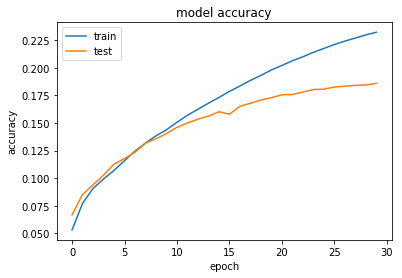

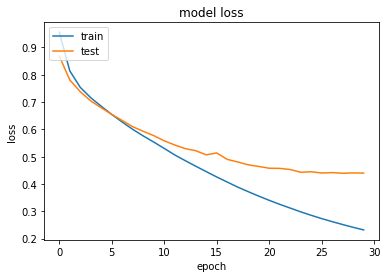

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()